In [1]:
import time

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

import torch 
from torch import nn
from torch.nn import functional as F
from torch.utils.data import TensorDataset, DataLoader

#np.random.seed(3)
#torch.manual_seed(3)

# Simulating Geometric Brownian Motion

We use the *Euler method* outlined in §6.3 of Shreve, 2004. Beginning at $S(0) = x$ and given some small $dt$, let

\begin{equation}
S(t + dt) = x + r S(t) dt + \sigma S(t) \sqrt{dt} \epsilon_1, 
\end{equation}

where $\epsilon_1$ ~ N(0, 1). Then

\begin{equation}
S(t + 2dt) = S(t + dt) + r S(t + dt) dt + \sigma S(t + dt) \sqrt{dt} \epsilon_2
\end{equation}
where $\epsilon_1$ ~ N(0, 1), and so on. We implement this exact algorithm below.

In [2]:
class GBM:
  def __init__(self, S0=100, r=0, sigma=0.01, T=21/253, dt=1/253): 
    self.S0 = S0
    self.r = r
    self.sigma = sigma
    self.T = T
    self.dt = dt
    #np.random.seed(3) # GBM paths will be the same every time

  # T=21 is chosen to correspond to an average of 21 trading days in a month
  # The denominator 253 corresponds to 253 trading days in a year

  # dt affects how close we want our approximation to be to a true Brownian motion. 
  # Lowering dt significantly increases computation time.
  # Setting dt=1 makes computation fast and interpretation simple.
  
  def generate_path(self):
    f = lambda x: x + self.r * x * self.dt + self.sigma * x * np.sqrt(self.dt) * np.random.normal()
    path = [self.S0]
    for i in range(1, int(self.T/self.dt)):
      path.append(f(path[i-1]))
    return path

  def generate_paths(self, n):
    paths = []
    for i in range(n):
      paths.append(self.generate_path())
    return paths

  def plot_paths(self, paths, n=20):
    plt.figure(figsize = (20, 5)) 
    plt.title(f'{len(paths)} Geometric Brownian Motion sample paths')
    plt.ylabel('Price')
    plt.xlabel('Ticks')
    for i in paths:
      plt.plot(i)

We have chosen sigma=0.1 below since it produces a variation in stock price which seems natural over the course of a trading month. Perhaps there is a better way to choose sigma.

In [3]:
gbm = GBM(S0 = 1, r=0, sigma=0.1)
sample_paths = GBM.generate_paths(gbm, 100)

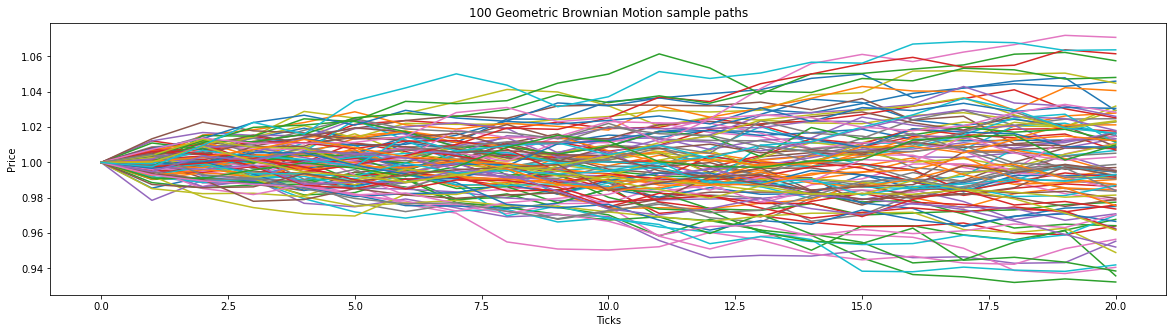

In [4]:
GBM.plot_paths(gbm, sample_paths)

We note that one quirk of the *Euler method* is that we cannot set $S = 0$, and that if $S > 0$, then $S(t) > 0$ for all $t \in \{0, \dots, T\}$.

# Fully recurrent network

The result of Chapter 2 of the dissertation is that we have reason to believe that a fully recurrent network structure is optimal for minimising global hedging error (hedging error over life of option); that is, for minimising
\begin{equation}
(Z - (\delta \cdot S)_{T} - p_0).
\end{equation}

The results of https://arxiv.org/pdf/1412.3555.pdf hint that GRUs and LSTMs outperform traditional RNNs. In addition, they hint that GRUs are simpler, and hence are easier to train. Therefore, we use a GRU as the recurrent unit in our RNN.

We used https://blog.floydhub.com/gru-with-pytorch/ as a guideline for writing the code, though it has been heavily modified.

In [5]:
def getGRU(input_size, hidden_size):
    net = nn.Sequential(
        nn.GRU(input_size, hidden_size, batch_first=True)
    )
    return net

# Could possibly use GRUCell instead https://pytorch.org/docs/stable/generated/torch.nn.GRUCell.html 

# To initialise weights differently, see
# https://discuss.pytorch.org/t/initializing-rnn-gru-and-lstm-correctly/23605

# Loss function

In https://nbviewer.org/urls/people.math.ethz.ch/~jteichma/lecture_ml_web/lecture_3.ipynb#, the loss function is given by 
\begin{equation}
\mathbb{\tilde{E}} [(Z - (\delta \cdot S)_{T} - p_0)^2]
\end{equation}
where "$Z$ denotes the payoff at maturity, $\delta$ the strategies to be learned and $p_0$ the price to be learned." This means $\delta$ and $p_0$ must be outputs of the model. 

The loss function can be understood as the expected value of the square of the total profit/loss from selling the option, maintaining a hedging portfolio until maturity, and paying out the option payoff at maturity. In theory, since our setting is a complete market (so we can set up a perfect hedge) under the risk-neutral measure, the value of this loss should be equal to the risk free rate $r$. Below we set $r=0$ for simplicity, so the loss for any minibatch of sample paths $\{S_1, \dots, S_B\}$ should be zero. During training, we seek to update the weights in our network in such a way that this loss converges to zero.

We can rewrite the loss for each minibatch as 
\begin{equation}
\frac{1}{B} \sum_{k=1}^{B} [(Z_k - (\delta_k \cdot S_k)_{T} - p_0)^2];
\end{equation}
We explain below the meaning of each term in the expression above.

### $p_0$
$p_0$ is the value of the option at $t=0$; it is the amount of cash available to set up the hedging portfolio at $t=0$, since it is the cash we get from selling the option at $t=0$. In fact, it can be interpreted as the minimum cost to set up the hedging portfolio, since we want to sell the option as cheaply as possible (we are competing with other sellers of options).

For each minibatch, we can estimate $p_0$ as follows, so that the model only has to learn  $\delta$ (the focus of this dissertation is hedging, not pricing). For all paths $S$ in a minibatch, we can assume that 
\begin{equation}
p_0 = \mathbb{\tilde{E}} \left[ e^{-rT} \left( \frac{1}{T} \int^{T}_{0} S(u) du - K \right)^{+} \bigg\rvert \mathcal{F}_0 \right] = 
\mathbb{\tilde{E}} \left[ e^{-rT} \left( \frac{1}{T} \int^{T}_{0} S(u) du - K \right)^{+} \right].
\end{equation} 

As in "Deep Hedging", we assume that each path in the minibatch is equally likely to be realised, so the expectation operator means that we just take an average over all paths in the minibatch. Then also assuming $r=0$ for simplicity,
\begin{equation}
p_0 = \frac{1}{B} \sum_{k=1}^{B} \left[ \left( \frac{1}{T} \int^{T}_{0} S_{k}(u) du - K \right)^{+} \right],
\end{equation} 
where each minibatch consists of $B$ paths $S_1, S_2, \dots, S_B$. If we also replace the integral in the Asian call payoff by an arithmetic average of the asset price, we have 
\begin{equation}
p_0 = \frac{1}{B} \sum_{k=1}^{B} \left[ \left( \frac{1}{T} \sum^{T-1}_{i=0} S_{k}(i) - K \right)^{+} \right].
\end{equation} 

Note, in https://nbviewer.org/urls/people.math.ethz.ch/~jteichma/lecture_ml_web/lecture_3.ipynb#, QuadraticHedgingLoss, which is used to train the model, is defined as above with $p=0$. Is this something to pay attention to?

### $Z_k$

$Z_k$ is just the payoff of the Asian call at maturity given that the underlying stock price is $S_k$. The subscript $k$ indicates that $Z_k$ is different for each sample path $S_k$ in the minibatch $\{S_1, \dots, S_B\}$. We have
\begin{equation}
Z_k = \left( \frac{1}{T} \sum^{T-1}_{i=0} S_k(i) - K \right)^{+},
\end{equation}
where $K$ is the strike price of the option.

### $(\delta_k \cdot S_k)_{T}$

For clarity, we omit the subscript $k$. We have
\begin{equation}
(\delta \cdot S)_{T}
 = \sum_{i=0}^{T-2} \delta(i) \cdot [S(i+1) - S(i)],
\end{equation}
where $\delta = (\delta(0), \dots, \delta(T-1))$ and $S = (S(0), \dots, S(T-1))$. 

It is clear that although our model will output $\delta(T-1)$, this is not used in calculating the loss (or anywhere else). This intuitiely makes sense, since the last element of the strategy $\delta$ is the amount of stock we should hold at the last trading time, but our option will expire at this exact time, so we don't actually need to hold any stock in our hedging portfolio at this time (we liquidate the hedging portfolio).

In [96]:
# We use this for training.
def training_loss(deltas, paths, payoffs):
    # Note, all operations use matrix algebra to preserve gradients
    deltas = torch.squeeze(deltas[:, :-1, :]) # Discard final value of delta for each delta in batch
    asset_price_differences = torch.squeeze(torch.diff(paths, n=1, dim=1)).float() # does not have gradient, as expected

    hedging_PL = torch.matmul(deltas, asset_price_differences.T) 
    hedging_PL = torch.matmul(torch.eye(batch_size), hedging_PL) # Throw away (delta_i \cdot S_j) if i ≠ j) by multiplying with identity
    hedging_PL = torch.sum(hedging_PL, dim=0) # reduce diagonal matrix to vector, all but one term in each sum is zero

    p_0 = torch.mean(payoffs) # p_0 is the average of payoffs for all paths in minibatch
    p_0 = torch.ones(batch_size) * p_0 # Reshape 

    portfolio_values = torch.squeeze(payoffs) - hedging_PL - p_0
    squared_portfolio_values = torch.square(portfolio_values) 
    loss = torch.mean(squared_portfolio_values) 
     
    return loss

# For model evaluation, same as above but don't square and take mean
def eval_loss(deltas, paths, payoffs):
    # Note, all operations use matrix algebra to preserve gradients
    deltas = torch.squeeze(deltas[:, :-1, :]) # Discard final value of delta for each delta in batch
    asset_price_differences = torch.squeeze(torch.diff(paths, n=1, dim=1)).float() # does not have gradient, as expected

    hedging_PL = torch.matmul(deltas, asset_price_differences.T) 
    hedging_PL = torch.matmul(torch.eye(batch_size), hedging_PL) # Throw away (delta_i \cdot S_j) if i ≠ j) by multiplying with identity
    hedging_PL = torch.sum(hedging_PL, dim=0) # reduce diagonal matrix to vector, all but one term in each sum is zero

    p_0 = torch.mean(payoffs) # p_0 is the average of payoffs for all paths in minibatch
    p_0 = torch.ones(batch_size) * p_0 # Reshape 

    portfolio_values = p_0 + hedging_PL - torch.squeeze(payoffs)

    return portfolio_values

# Create training set

Now, we generate our sample paths and create labels for our sample paths, in order to use the supervised learning approach to train the network. In https://nbviewer.org/urls/people.math.ethz.ch/~jteichma/lecture_ml_web/lecture_3.ipynb#, the label for each *entire* sample path is just the European call payoff 
\begin{equation}
(S(T) - K)^{+}.
\end{equation}
If our sample path was e.g. $S = (100, 101, 102)$, then the label for this path would just be 2.

Since we would like to learn the hedging strategy for an Asian call, the label for each *entire* sample path should just be the Asian call payoff
\begin{equation}
\left( \frac{1}{T} \int^{T}_{0} S(u) du - K \right)^{+}.
\end{equation}

In [ ]:
T = 21 # T=21 is chosen to correspond to an average of 21 trading days in a month
S0 = 1 # Note: model is degenerate for S0 of order of 100 and larger. Why? I don't think it has anything to do with learning rate.
r = 0
sigma = 0.1 

gbm = GBM(S0, r, sigma, T=T/253, dt=1/253) 
n_paths = 10000 # Number of GBM sample paths to generate
batch_size = 250

In [ ]:
'''
def asian_call_payoff(path, K=95):
    # We use the trapezium rule to calculate the integral.
    integral =  lambda x: 0.5 * (x[0] + 2 * sum(x[1:-1]) + x[-1]) 
    return max((1 / len(path)) * integral(path) - K, 0)
'''

def asian_call_payoff(path, K=S0):
    return max(np.mean(path) - K, 0)

In [ ]:
def generate_labels(sample_paths):
    payoffs = []
    for path in sample_paths:
        payoff = asian_call_payoff(path)
        payoffs.append(payoff)
    return payoffs

train_sample_paths = GBM.generate_paths(gbm, n_paths)
train_payoffs = generate_labels(train_sample_paths)

train_data = TensorDataset(torch.tensor(train_sample_paths).reshape(-1, T, 1), torch.tensor(train_payoffs).reshape(-1, 1))
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, drop_last=True)

# Train model

Below, we set hidden_size = 1, since in theory we expect that the RNN only needs to "remember" one state variable in order to estimate the hedging strategy. This state variable, we expect, should be (a function of) the integrated stock price $Y$ over the lifetime of the option.

In [10]:
# using function getGRU
def train(T, train_loader, batch_size, lr, loss_function, num_epochs=5):
    input_size = 1 
    hidden_size = 1 

    net = getGRU(input_size, hidden_size)
    #net.apply(init_weights);
    
    optimiser = torch.optim.Adam(net.parameters(), lr=lr)

    epoch_times = []
    for epoch in range(1, num_epochs+1):
        start_time = time.perf_counter()
        sum_batch_losses = 0.
        batches_processed = 0

        for paths, payoffs in train_loader: 
            # paths.shape = (batch_size, T, 1)
            # payoffs.shape = (batch_size, 1)
            batches_processed += 1

            optimiser.zero_grad()
            
            delta, h = net(paths.float()) 
            # out.shape = (batch_size, T, output_size)
            # h.shape = (num_layers, batch_size, hidden_size)
            
            loss = loss_function(delta, paths, payoffs) 
            loss.backward()
            optimiser.step()

            sum_batch_losses += loss.item() 
            
            '''
            if batches_processed%batch_size == 0:
                print("Epoch {}......Step: {}/{}....... Average Loss for epoch so far: {}".format(
                    epoch, batches_processed, len(train_loader), sum_batch_losses/batches_processed))
            '''
            
        end_time = time.perf_counter()
        print("Epoch {}/{} done, Average Loss: {}".format(epoch, num_epochs, sum_batch_losses/len(train_loader)))
        print("Epoch time: {} seconds".format(str(end_time-start_time)))
        epoch_times.append(end_time-start_time)
    
    print("Total Training Time: {} seconds".format(str(sum(epoch_times))))

    return net

In [11]:
lr = 0.05
trained_net = train(T, train_loader, batch_size, lr, training_loss)

Epoch 1/5 done, Average Loss: 0.04047938265618235
Epoch time: 0.5404870310000014 seconds
Epoch 2/5 done, Average Loss: 0.0002481964352660144
Epoch time: 0.4001044819999997 seconds
Epoch 3/5 done, Average Loss: 6.937008323823058e-05
Epoch time: 0.40196298599999913 seconds
Epoch 4/5 done, Average Loss: 6.874610931501129e-05
Epoch time: 0.4933215880000006 seconds
Epoch 5/5 done, Average Loss: 6.763434065143582e-05
Epoch time: 0.3959131780000007 seconds
Total Training Time: 2.2317892650000015 seconds


In [53]:
# Sanity check
# We want to check that delta, h are non-constant, non-zero
# i.e non-degenerate
for X, y in train_loader:
    delta, h = trained_net(X.float()) 
    print(delta[0])
    print()
    print(h)
    break

tensor([[9.1849e-05],
        [3.7351e-04],
        [7.7774e-04],
        [1.3013e-03],
        [1.8812e-03],
        [2.4234e-03],
        [2.9450e-03],
        [3.4768e-03],
        [3.9690e-03],
        [4.4484e-03],
        [4.9034e-03],
        [5.3773e-03],
        [5.7485e-03],
        [6.0355e-03],
        [6.2335e-03],
        [6.4210e-03],
        [6.6483e-03],
        [6.7228e-03],
        [6.7714e-03],
        [6.7409e-03],
        [6.7667e-03]], grad_fn=<SelectBackward0>)

tensor([[[ 6.7667e-03],
         [-4.9998e-03],
         [ 3.4674e-03],
         [ 4.7239e-03],
         [-4.3213e-03],
         [-3.6280e-03],
         [ 1.8216e-03],
         [-2.7296e-03],
         [-4.4037e-04],
         [-9.4397e-04],
         [-1.0555e-05],
         [-2.2264e-04],
         [ 8.8068e-03],
         [ 2.8766e-03],
         [ 4.7414e-03],
         [ 1.2985e-02],
         [ 1.6399e-03],
         [ 2.5183e-03],
         [-3.4636e-03],
         [-3.8933e-03],
         [ 1.0582e-03],
     

### Observation

It seems as though just setting $\delta=(0, \dots, 0)$ gives the smallest loss. Indeed, a lot of the time, the payoff $Z$ is equal to zero and $p_0$ is therefore very close to 0. Hence, we end up minimising 
\begin{equation}
\mathbb{\tilde{E}} [(\delta \cdot S)_{T}],
\end{equation}
which of course leads to $\delta=(0, \dots, 0)$, or at least something very close to that.

Even in the case of a European call, this is probably happening, but to a lesser extent I think, since average of stock price minus strike is generally a lot smaller than difference between stock price and strike at maturity.

# Evaluation

We refer to $(p_0 + (\delta \cdot S)_{T} - Z)$ as the "trade profit" associated with each sample path, where this sample path is the underlying price process for the "trade", which means selling an Asian call and hedging this short position.

In [92]:
# Simulate test data
test_sample_paths = GBM.generate_paths(gbm, n_paths)
test_payoffs = generate_labels(test_sample_paths)

test_data = TensorDataset(torch.tensor(test_sample_paths).reshape(-1, T, 1), torch.tensor(test_payoffs).reshape(-1, 1))
test_loader = DataLoader(test_data, shuffle=False, batch_size=batch_size, drop_last=True) # shuffle is False for convenience

In [93]:
hidden_states = []
path_averages = []
path_losses = []

for paths, payoffs in test_loader:     
    delta, h = trained_net(paths.float()) 
    loss = eval_loss(delta, paths, payoffs) 
    hidden_states.extend(list(torch.squeeze(h))) # A single number is output as the 'final' hidden state for each path
    path_averages.extend(list(torch.squeeze(torch.mean(paths, dim=1)))) # Record the average price of each path
    path_losses.extend(loss.detach().numpy()) # Record the hedging error for each path 

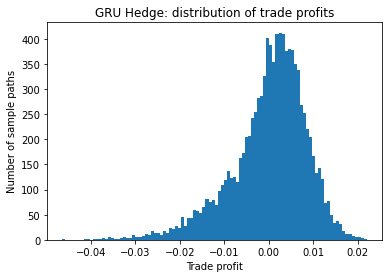

In [94]:
plt.title("GRU Hedge: distribution of trade profits")
plt.xlabel("Trade profit")
plt.ylabel("Number of sample paths")
plt.hist(path_losses, bins=100);

In [95]:
print(f"Mean trade profit across test set: {np.mean(path_losses)}")

Mean trade profit across test set: 9.042414628768046e-05


We should be able to achieve a more symmetric distribution, and a mean profit closer to zero, by improving the training process. Recall that we expect the mean profit to be zero, since we are pricing under the risk-neutral measure, under which all risky assets have expected return equal to the risk-free rate, and we have assumed $r=0$ for simplicity. We perform some sanity checks below.

First, we plot the trade profits for an untrained "naive" model. As expected, there is huge variance in trade profit for the untrained "naive" model, compared to the trained GRU hedge. Then we think about not hedging at all. I.e. what if we set $\delta = (0, \dots, 0)$ (naked call)? As above, there is huge variance in trade profit if we just don't hedge, compared to the GRU hedge. Finally, what about the covered call hedging strategy? I.e. what if we set $\delta = (1, \dots, 1)$ (covered call)? Once again, we are exposed to much more risk if we follow this hedging strategy, compared to followning the network hedge.

In [97]:
untrained_net  = getGRU(1, 1)
path_losses_untrained = []
path_losses_naked = []
path_losses_covered = []

for paths, payoffs in test_loader:     
    delta, h = untrained_net(paths.float()) 
    loss = eval_loss(delta, paths, payoffs) 
    path_losses_untrained.extend(loss.detach().numpy()) # Record the hedging error for each path 

    naked_loss = eval_loss(torch.zeros(batch_size, T, 1), paths, payoffs) 
    path_losses_naked.extend(naked_loss.detach().numpy()) # Record the hedging error for each path 
    
    loss = eval_loss(torch.ones(batch_size, T, 1), paths, payoffs) 
    path_losses_naked.extend(loss.detach().numpy()) # Record the hedging error for each path 

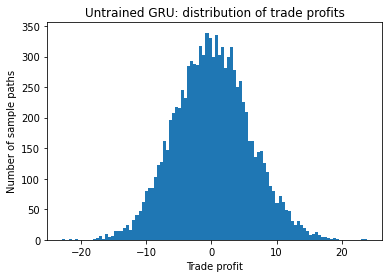

In [99]:
plt.title("Untrained GRU: distribution of trade profits")
plt.xlabel("Trade profit")
plt.ylabel("Number of sample paths")
plt.hist(path_losses_untrained, bins=100);

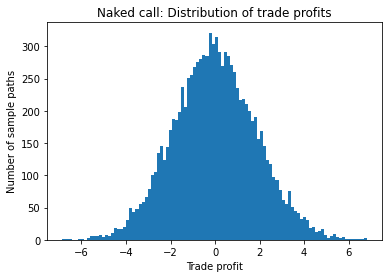

In [84]:
plt.title("Naked call: Distribution of trade profits")
plt.xlabel("Trade profit")
plt.ylabel("Number of sample paths")
plt.hist(path_losses_untrained, bins=100);

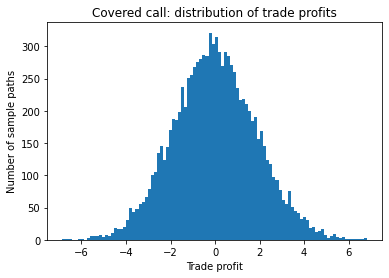

In [81]:
plt.title("Covered call: distribution of trade profits")
plt.xlabel("Trade profit")
plt.ylabel("Number of sample paths")
plt.hist(path_losses_untrained, bins=100);

# Correlation between hidden state and average price

We make a hypothesis that the final hidden state is a function of the average of the stock price over the entire sample path. This is because we expect the hidden state between each copy of the GRU cell (when the network is viewed in its unfolded form) to be a function of the average stock price *so far*. 

This is based on the theoretical result that the hedge at time $t$ only depends on the stock price at time $t$ and the average of the stock price between time 0 and time $t$, as well as the intuition that an RNN learns to 'store' relevant information from the input sequence in its hidden state.

In [102]:
print("Correlation between hidden states and average stock prices")
torch.corrcoef(torch.tensor([hidden_states, path_averages]))

Correlation between hidden states and average stock prices


tensor([[1.0000, 0.9977],
        [0.9977, 1.0000]], dtype=torch.float64)

The matrix above indicates a **very strong** linear relationship between the final hidden state, which we expect to be a function of the average of the stock price over the entire sample path, and the actual average of the stock price over the entire sample path. Therefore we are very far from rejecting our hypothesis.

Below, we do a couple of sanity checks. As expected, the correlation between random vectors is near 0. The correlation between the final hidden state and the final stock price for each path is close to one in absolute value, as we might expect since the average stock price is a function of the final stock price, but the correlation is much weaker than the one between hidden state and average stock price.

In [100]:
print("Correlation between random vectors")
torch.corrcoef(torch.randn(2, 10000))

Correlation between random vectors


tensor([[1.0000, 0.0079],
        [0.0079, 1.0000]])

In [101]:
final_stock_prices = []

for paths, payoffs in test_loader:     
    final_stock_prices.extend(list(paths[:, -1, :]))

print("Correlation between hidden states and terminal stock prices")
torch.corrcoef(torch.tensor([hidden_states, final_stock_prices]))

Correlation between hidden states and terminal stock prices


tensor([[1.0000, 0.9035],
        [0.9035, 1.0000]], dtype=torch.float64)